# Reconstruct original measurement data

Now, we will reconstruct an object from real measured data.
First, some imports.

In [1]:
import CA_calculations_c as cac
import shownet
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

The data to reconstruct is the Muster1_015 measured in 19KW48. Geometrical patterns printed with different elements, exposure time ~16 minutes.
shownet has the possibility to get the spectrum (shownet.getspec('filename')), to chose directly the channel region to be displayed (shownet.getnet('filename',startchannel,endchannel)) or to make a non negative matrix factorization (shownet.makenmf('filename')). To change the parameters of the nmf you have to change the code in shownet. 

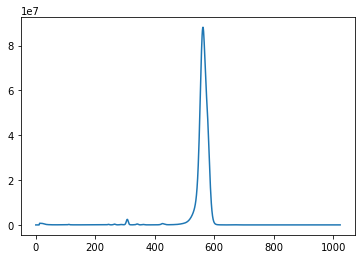

In [2]:
specM1 = shownet.getspec('Muster1_015')
plt.plot(specM1)

We see a huge scatter peak, but the region of interest is more likely between channels 200 and 400.

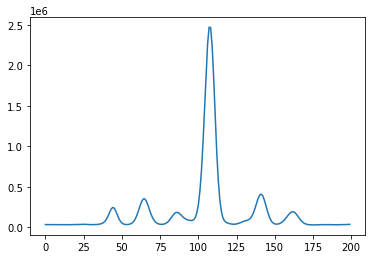

In [5]:
plt.plot(specM1[200:400])

We can now have a look at the different regions of interest/peaks one by one.

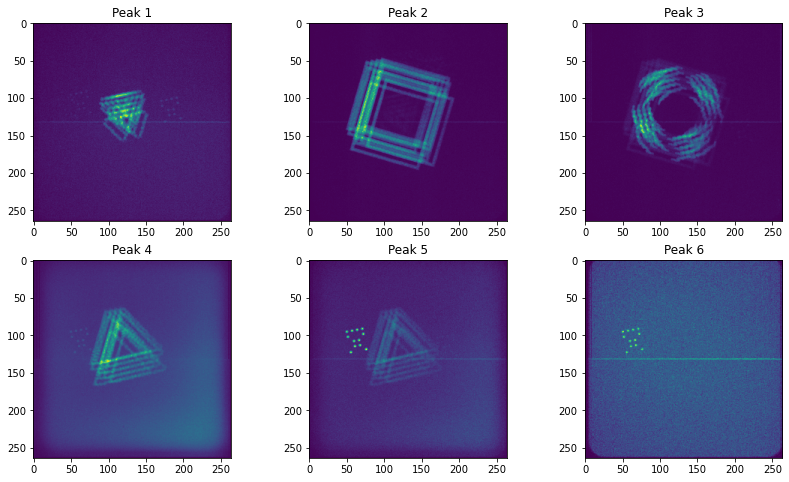

In [11]:
p1start, p1stop = 235,250
p2start, p2stop = 255,270
p3start, p3stop = 280,295
p4start, p4stop = 300,315
p5start, p5stop = 330,350
p6start, p6stop = 355,370
fig2 = plt.figure(6,figsize=(14,8))
ax21 = fig2.add_subplot(231)
ax21.imshow(shownet.getnet('Muster1_015',p1start,p1stop))
ax21.set_title('Peak 1')
ax22 = fig2.add_subplot(232)
ax22.imshow(shownet.getnet('Muster1_015',p2start,p2stop))
ax22.set_title('Peak 2')
ax23 = fig2.add_subplot(233)
ax23.imshow(shownet.getnet('Muster1_015',p3start,p3stop))
ax23.set_title('Peak 3')
ax24 = fig2.add_subplot(234)
ax24.imshow(shownet.getnet('Muster1_015',p4start,p4stop))
ax24.set_title('Peak 4')
ax25 = fig2.add_subplot(235)
ax25.imshow(shownet.getnet('Muster1_015',p5start,p5stop))
ax25.set_title('Peak 5')
ax26 = fig2.add_subplot(236)
ax26.imshow(shownet.getnet('Muster1_015',p6start,p6stop))
ax26.set_title('Peak 6')
plt.show(block=False)

Or we can just make a nmf and look what it finds as components.

C:\apps\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


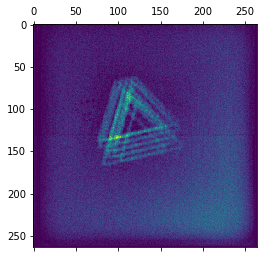

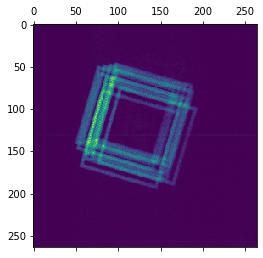

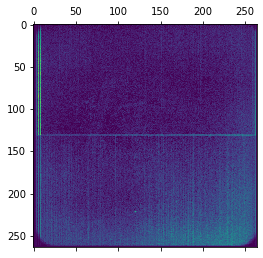

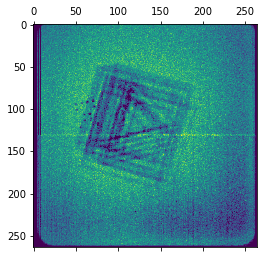

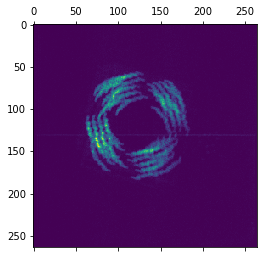

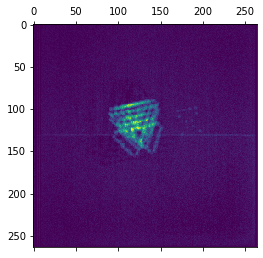

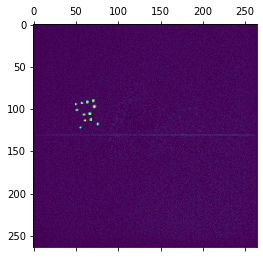

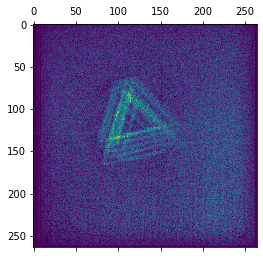

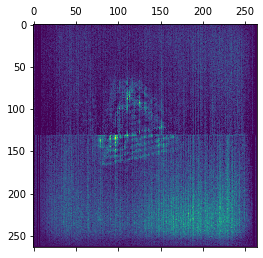

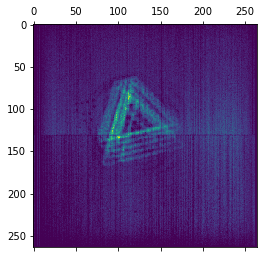

In [12]:
w1,w2,w3,w4,w5,H = shownet.makenmf('Muster1_015')

Let's have a look at the different components. We show the detector image, the original spectrum and the found component spectrum.

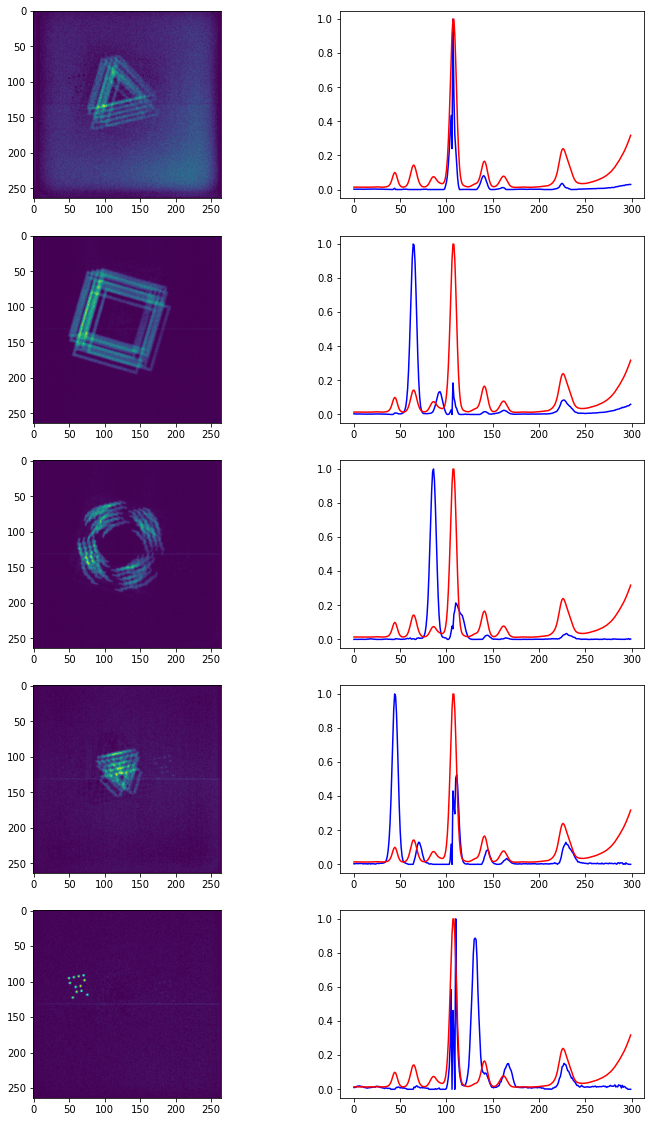

In [18]:
fig3 = plt.figure(10,figsize=(12,20))
ax31 = fig3.add_subplot(5,2,1)
ax31.imshow(w1)
ax32 = fig3.add_subplot(5,2,2)
ax32.plot(H[0][150:450]/H[0].max(),'b-',specM1[200:500]/specM1[200:500].max(),'r-')
ax33 = fig3.add_subplot(5,2,3)
ax33.imshow(w2)
ax34 = fig3.add_subplot(5,2,4)
ax34.plot(H[1][150:450]/H[1].max(),'b-',specM1[200:500]/specM1[200:500].max(),'r-')
ax35 = fig3.add_subplot(5,2,5)
ax35.imshow(w3)
ax36 = fig3.add_subplot(5,2,6)
ax36.plot(H[4][150:450]/H[4].max(),'b-',specM1[200:500]/specM1[200:500].max(),'r-')
ax37 = fig3.add_subplot(5,2,7)
ax37.imshow(w4)
ax38 = fig3.add_subplot(5,2,8)
ax38.plot(H[5][150:450]/H[5].max(),'b-',specM1[200:500]/specM1[200:500].max(),'r-')
ax39 = fig3.add_subplot(5,2,9)
ax39.imshow(w5)
ax310 = fig3.add_subplot(5,2,10)
ax310.plot(H[6][150:450]/H[6].max(),'b-',specM1[200:500]/specM1[200:500].max(),'r-')

This is our data that we want to reconstruct.
We know the mask, the distances d1 and d2 and the angle of rotation relative to the detector, this is all we need to build the mstf (projection function). 

In [19]:
mask1 = cac.pmmask(5,1,1) #the mask is a mura mask of module 5 with one pixel separation between two hole-pixels

detlength = 264     # detlength in pixel, assumed to be square
detpixsize = 48     # size of a detector pixel in µm
masksize = 1000     # physical size of the mask in µm
maskholesize = 90   # diameter of a hole, assumed to be a circle, in µm
maskthickness = 25  # thickness of the mask
rotation = 281.31   # rotation of the mask relative to the detector in °
obpixsize = 100     # size of one reconstructed object pixel
d1 = 10             # distance between object and mask
d2 = 6.05           # distance between mask and detector
pcfov = 1           # pcfov = 0 => only the fully coded field of view is considered, pcfov = 1 => the partially 
                    # coded field of view is also considered
norm = 1            # the transferfunction is "normed", so that each hole in the mask adds a total intensity of 1 to the
                    # detector image

mstf1 = cac.buildmatf_for_reconstruction(mask1,detlength,detpixsize,masksize,maskholesize,maskthickness,rotation,
                                         obpixsize,d1,d2,pcfov,norm)


start at:  Thu Feb 18 15:34:30 2021
slope =  3.6
computation time:  232.7756462097168


Let's check the number of object pixels by displaying the shape of the mstf:

In [22]:
nofobpix = np.shape(mstf1)[1]
print('Number of object pixels: ', nofobpix,'; that is ', np.sqrt(nofobpix),'x', np.sqrt(nofobpix), ' pixels.')

Number of object pixels:  55696 ; that is  236.0 x 236.0  pixels.


We can have a look on the projection of a single point and compare it to the projected mask. (Play around with the location of the "1" in needletip to put the simulated and real projected mask together.)

Time to calculate the projection:  0.04697299003601074  seconds


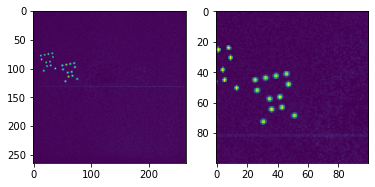

In [33]:
needletip = np.zeros([236,236])
#needletip[136,170] = 1
needletip[150,200] = 1
needletippro = cac.sparse_projection(needletip,mstf1)
needletippro2d = cac.from122(needletippro,264,264)
fig4 = plt.figure(2)
ax41 = fig4.add_subplot(121)
ax41.imshow(needletippro2d/needletippro2d.max()+w5/w5.max())
ax42 = fig4.add_subplot(122)
ax42.imshow(needletippro2d[50:150,25:125]/needletippro2d.max()+w5[50:150,25:125]/w5.max())

If we think that the mstf matches pretty well, we can perform the reconstruction. Chose one of the components or all at once.

start at:  Thu Feb 18 16:00:09 2021
0 / 500
tf.Tensor(0.1887104, shape=(), dtype=float32)
1 / 500
tf.Tensor(0.58916557, shape=(), dtype=float32)
2 / 500
tf.Tensor(0.17084774, shape=(), dtype=float32)
3 / 500
tf.Tensor(0.11305657, shape=(), dtype=float32)
4 / 500
tf.Tensor(0.09328431, shape=(), dtype=float32)
5 / 500
tf.Tensor(0.078820154, shape=(), dtype=float32)
6 / 500
tf.Tensor(0.068829425, shape=(), dtype=float32)
7 / 500
tf.Tensor(0.06220197, shape=(), dtype=float32)
8 / 500
tf.Tensor(0.057882965, shape=(), dtype=float32)
9 / 500
tf.Tensor(0.05444541, shape=(), dtype=float32)
10 / 500
tf.Tensor(0.05175026, shape=(), dtype=float32)
11 / 500
tf.Tensor(0.05022219, shape=(), dtype=float32)
12 / 500
tf.Tensor(0.04920947, shape=(), dtype=float32)
13 / 500
tf.Tensor(0.047367387, shape=(), dtype=float32)
14 / 500
tf.Tensor(0.04472642, shape=(), dtype=float32)
15 / 500
tf.Tensor(0.042600192, shape=(), dtype=float32)
16 / 500
tf.Tensor(0.041248318, shape=(), dtype=float32)
17 / 500
tf.Tenso

144 / 500
tf.Tensor(0.028115265, shape=(), dtype=float32)
145 / 500
tf.Tensor(0.028113814, shape=(), dtype=float32)
146 / 500
tf.Tensor(0.028112387, shape=(), dtype=float32)
147 / 500
tf.Tensor(0.028110983, shape=(), dtype=float32)
148 / 500
tf.Tensor(0.028109597, shape=(), dtype=float32)
149 / 500
tf.Tensor(0.028108228, shape=(), dtype=float32)
150 / 500
tf.Tensor(0.028106896, shape=(), dtype=float32)
151 / 500
tf.Tensor(0.02810562, shape=(), dtype=float32)
152 / 500
tf.Tensor(0.02810443, shape=(), dtype=float32)
153 / 500
tf.Tensor(0.02810329, shape=(), dtype=float32)
154 / 500
tf.Tensor(0.028102215, shape=(), dtype=float32)
155 / 500
tf.Tensor(0.028101195, shape=(), dtype=float32)
156 / 500
tf.Tensor(0.02810023, shape=(), dtype=float32)
157 / 500
tf.Tensor(0.028099323, shape=(), dtype=float32)
158 / 500
tf.Tensor(0.0280984, shape=(), dtype=float32)
159 / 500
tf.Tensor(0.028097456, shape=(), dtype=float32)
160 / 500
tf.Tensor(0.028096486, shape=(), dtype=float32)
161 / 500
tf.Tensor(

tf.Tensor(0.02804879, shape=(), dtype=float32)
286 / 500
tf.Tensor(0.028048685, shape=(), dtype=float32)
287 / 500
tf.Tensor(0.028048584, shape=(), dtype=float32)
288 / 500
tf.Tensor(0.028048482, shape=(), dtype=float32)
289 / 500
tf.Tensor(0.028048374, shape=(), dtype=float32)
290 / 500
tf.Tensor(0.02804827, shape=(), dtype=float32)
291 / 500
tf.Tensor(0.028048173, shape=(), dtype=float32)
292 / 500
tf.Tensor(0.028048089, shape=(), dtype=float32)
293 / 500
tf.Tensor(0.02804801, shape=(), dtype=float32)
294 / 500
tf.Tensor(0.02804794, shape=(), dtype=float32)
295 / 500
tf.Tensor(0.028047865, shape=(), dtype=float32)
296 / 500
tf.Tensor(0.02804778, shape=(), dtype=float32)
297 / 500
tf.Tensor(0.028047683, shape=(), dtype=float32)
298 / 500
tf.Tensor(0.028047567, shape=(), dtype=float32)
299 / 500
tf.Tensor(0.028047444, shape=(), dtype=float32)
300 / 500
tf.Tensor(0.028047312, shape=(), dtype=float32)
301 / 500
tf.Tensor(0.02804719, shape=(), dtype=float32)
302 / 500
tf.Tensor(0.02804707

tf.Tensor(0.02804154, shape=(), dtype=float32)
429 / 500
tf.Tensor(0.028041525, shape=(), dtype=float32)
430 / 500
tf.Tensor(0.028041506, shape=(), dtype=float32)
431 / 500
tf.Tensor(0.028041491, shape=(), dtype=float32)
432 / 500
tf.Tensor(0.028041473, shape=(), dtype=float32)
433 / 500
tf.Tensor(0.02804146, shape=(), dtype=float32)
434 / 500
tf.Tensor(0.028041441, shape=(), dtype=float32)
435 / 500
tf.Tensor(0.028041428, shape=(), dtype=float32)
436 / 500
tf.Tensor(0.028041415, shape=(), dtype=float32)
437 / 500
tf.Tensor(0.028041404, shape=(), dtype=float32)
438 / 500
tf.Tensor(0.028041394, shape=(), dtype=float32)
439 / 500
tf.Tensor(0.028041385, shape=(), dtype=float32)
440 / 500
tf.Tensor(0.02804138, shape=(), dtype=float32)
441 / 500
tf.Tensor(0.028041368, shape=(), dtype=float32)
442 / 500
tf.Tensor(0.028041353, shape=(), dtype=float32)
443 / 500
tf.Tensor(0.028041335, shape=(), dtype=float32)
444 / 500
tf.Tensor(0.028041316, shape=(), dtype=float32)
445 / 500
tf.Tensor(0.02804

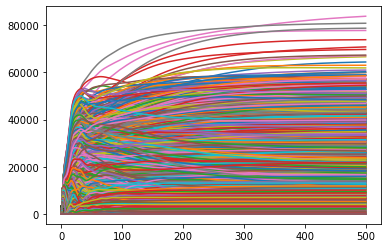

In [38]:
data_to_reconstruct = cac.from221(w2 + w3)
x0 = tf.Variable(tf.random.uniform([np.shape(mstf1)[1],1]))
# x0 = tf.Variable(tf.ones([np.shape(mstf1)[1],1]))
# x0 = tf.Variable(tf.zeros([np.shape(mstf1)[1],1]))
steps = 500
learningrate = 5000

reconstruction = cac.c_sparse(data_to_reconstruct,mstf1,x0,max_iter=steps,lr=learningrate)

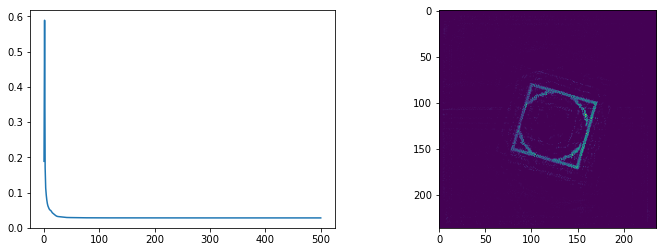

In [46]:
fig5 = plt.figure(2,figsize=(12,4))
ax51 = fig5.add_subplot(121)
ax51.plot(reconstruction[2])
ax52 = fig5.add_subplot(122)
ax52.imshow(reconstruction[0])

You can repeat the reconstruction with a new mstf and see what changes.